# Обучение с подкреплением
## Бодунов П.А. ФКТИ 0310
## Практическая №2 (PPO)

Установка gym:

In [9]:
!pip install gym==0.26.2

Необходимые библиотеки и выбор девайса:

In [10]:
import math
import random
from collections import namedtuple, deque
from itertools import count
from typing import Type
from gymnasium.wrappers import RecordVideo
import gymnasium as gym
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.distributions import Categorical, Normal
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)

In [11]:
print(device)

cpu


Параметры нейронной сети:

In [12]:
@dataclass
class Params:
    num_episodes: int = 300
    epochs: int = 10
    batch_size: int = 64
    gamma: float = 0.99
    steps_trajectory: int = 1024
    lamb: float = 0.95
    clip_ratio: float = 0.2
    value_coef: float = 0.5
    entropy_coef: float = 0.01
    lr_actor: float = 3e-4
    lr_critic: float = 1e-3
    normalize_advantages: bool = True

### Actor

In [13]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(Actor, self).__init__()
        self.shared_net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )
        self.mean_net = nn.Linear(hidden_size, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        shared_features = self.shared_net(x)
        mean = self.mean_net(shared_features)
        return mean, self.log_std.exp()

    def get_dist(self, state):
        mean, std = self.forward(state)
        return Normal(mean, std)

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            dist = self.get_dist(state)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)
        return action.cpu().numpy().flatten(), log_prob.item()

- `get_dist(self, state)` - получение распределения
- `act(self, state)` - выбор действия

### Critic

In [14]:
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size=64):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, state):
        return self.net(state).flatten()

### DQNAgent

In [15]:
class PPOAgent:
    def __init__(self, env: gym.Env, params: Params = None):
        self.env = env
        self.params = params if params else Params()

        state_dim = env.observation_space.shape[0]
        self.is_continuous = isinstance(env.action_space, gym.spaces.Box)
        action_dim = env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n

        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.params.lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.params.lr_critic)

    def compute_gae(self, rewards, values, dones):
        advantages = np.zeros_like(rewards)
        last_gae = 0

        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[t + 1]

            delta = rewards[t] + self.params.gamma * next_value * (1 - dones[t]) - values[t]
            advantages[t] = delta + self.params.gamma * self.params.lamb * last_gae * (1 - dones[t])
            last_gae = advantages[t]

        returns = advantages + values
        if self.params.normalize_advantages:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        return returns, advantages

    def collect_trajectories(self, env):
        states, actions, log_probs, rewards, dones = [], [], [], [], []
        episode_rewards = []

        state, _ = env.reset()
        ep_reward = 0.0

        for _ in range(self.params.steps_trajectory):
            action, log_prob = self.actor.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            dones.append(done)

            ep_reward += reward
            state = next_state

            if done:
                episode_rewards.append(ep_reward)
                state, _ = env.reset()
                ep_reward = 0.0

        if len(episode_rewards) == 0 or ep_reward > 0:
           episode_rewards.append(ep_reward)

        with torch.no_grad():
            values = self.critic(torch.FloatTensor(states).to(device)).cpu().numpy()

        returns, advantages = self.compute_gae(rewards, values, dones)

        return {
            "states": np.array(states),
            "actions": np.array(actions),
            "log_probs": np.array(log_probs),
            "returns": np.array(returns),
            "advantages": np.array(advantages),
            "episode_rewards": np.array(episode_rewards)
        }

    def update(self, batch):
        states = torch.FloatTensor(batch["states"]).to(device)
        actions = torch.LongTensor(batch["actions"]).to(device)
        old_log_probs = torch.FloatTensor(batch["log_probs"]).to(device)
        returns = torch.FloatTensor(batch["returns"]).to(device)
        advantages = torch.FloatTensor(batch["advantages"]).to(device)

        dataset_size = states.size(0)
        indices = np.arange(dataset_size)

        iteration_loss = []

        for _ in range(self.params.epochs):
            np.random.shuffle(indices)

            for start in range(0, dataset_size, self.params.batch_size):
                end = start + self.params.batch_size
                if end > dataset_size:
                    end = dataset_size
                idx = indices[start:end]

                batch_states = states[idx]
                batch_actions = actions[idx]
                batch_old_log_probs = old_log_probs[idx]
                batch_returns = returns[idx]
                batch_advantages = advantages[idx]

                dist = self.actor.get_dist(batch_states)
                new_log_probs = dist.log_prob(batch_actions).sum(dim=-1)

                ratio = torch.exp(new_log_probs - batch_old_log_probs)

                entropy_loss = dist.entropy().mean()

                surr1 = ratio * batch_advantages
                surr2 = (torch.clamp(ratio, 1.0 - self.params.clip_ratio, 1.0 + self.params.clip_ratio) * batch_advantages)

                actor_loss = -torch.min(surr1, surr2).mean()

                values = self.critic(batch_states)
                critic_loss = nn.functional.mse_loss(values, batch_returns)

                loss = actor_loss + self.params.value_coef * critic_loss - self.params.entropy_coef * entropy_loss

                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()
                loss.backward()
                self.actor_optimizer.step()
                self.critic_optimizer.step()

                iteration_loss.append(loss.item())

        return iteration_loss

- `select_action(self, state)` - выбор действия на основе состояния state.
- `train_step(self)` - шаг обучения.
- `update_epsilon(self)` - обновление $\varepsilon$ для $\varepsilon$-жадной политики.
- `update_target(self)` - обновление таргетной сетки новыми значениями q-сетки.

### Обучение нейронной сети

In [16]:
def train(agent, env):
    reward_history = []
    loss_history = []
    episode_tqdm = tqdm(range(agent.params.num_episodes))
    for episode in episode_tqdm:
        batch = agent.collect_trajectories(env)

        iteration_loss = agent.update(batch)

        avg_loss = np.mean(iteration_loss)
        avg_reward = np.mean(batch["episode_rewards"])

        reward_history.append(avg_reward)
        loss_history.append(avg_loss)

        episode_tqdm.desc = f"Avg Reward: {avg_reward}, Loss: {avg_loss}"

        if avg_reward >= env.spec.reward_threshold:
            print(f"\nTask is completed for {episode} episodes")
            break

    return reward_history, loss_history


### Функция построения графиков

In [17]:
def plot_graphics(results, labels, main_title):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 6))
    fig.tight_layout(pad=5.0)
    fig.suptitle(main_title, fontsize=14)

    ax1.set_title("Reward")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Reward')
    ax1.grid(True)

    ax2.set_title("Loss")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    for (rewards, losses), label in zip(results, labels):
        ax1.plot(rewards, label=label)
        ax2.plot(losses, label=label)

    ax1.legend()
    ax2.legend()

    plt.show()

#### Эксперимент, как длина траектории влияет на скорость обучения

In [32]:
def experiment_steps_trajectory(env):
    steps_trajectories = [512, 1024, 2048]
    labels = []
    results = []
    for steps_trajectory in steps_trajectories:
        label = f"steps_trajectory = {steps_trajectory}"
        labels.append(label)
        agent = PPOAgent(env, Params(steps_trajectory=steps_trajectory))

        print(f"{label} model train")
        results.append(train(agent, env))

    plot_graphics(results, labels, "Steps trajectory")

#### Эксперимент, как clip_ratio влияет на скорость обучения

In [19]:
def experiment_clip_ratio(env):
    clip_ratios = [0.1, 0.2, 0.3]
    labels = []
    results = []
    for clip_ratio in clip_ratios:
        label = f"clip_ratio = {clip_ratio}"
        labels.append(label)
        agent = PPOAgent(env, Params(clip_ratio=clip_ratio))

        print(f"{label} model train")
        results.append(train(agent, env))

    plot_graphics(results, labels, "Clip ratio")

#### Эксперимент, как нормализация преимуществ влияет на скорость обучения

In [20]:
def experiment_normalize_advantages(env):
    normalizations = [True, False]
    labels = []
    results = []
    for normalize_advantages in normalizations:
        label = f"normalize_advantages = {normalize_advantages}"
        labels.append(label)
        agent = PPOAgent(env, Params(normalize_advantages=normalize_advantages))

        print(f"{label} model train")
        results.append(train(agent, env))

    plot_graphics(results, labels, "Normalize advantages")

#### Эксперимент, как количествах эпох влияет на скорость обучения

In [21]:
def experiment_epoch(env):
    epochs = [10, 20, 30]
    labels = []
    results = []
    for epoch in epochs:
        label = f"epochs = {epoch}"
        labels.append(label)
        agent = PPOAgent(env, Params(epochs=epoch))

        print(f"{label} model train")
        results.append(train(agent, env))

    plot_graphics(results, labels, "Epoch")

Окружение CartPole

In [22]:
env = gym.make("MountainCarContinuous-v0")

## Эксперименты

steps_trajectory = 512 model train


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-15-084871a5820f>:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  values = self.critic(torch.FloatTensor(states).to(device)).cpu().numpy()
Avg Reward: -13.286186639022914, Loss: 0.4302637273445725: 100%|██████████| 300/300 [02:41<00:00,  1.86it/s]


steps_trajectory = 1024 model train


Avg Reward: -21.926905147591523, Loss: 0.1791355502558872: 100%|██████████| 300/300 [05:26<00:00,  1.09s/it]


steps_trajectory = 2048 model train


Avg Reward: 90.30326646722453, Loss: 3.913007029518485:  73%|███████▎  | 219/300 [07:58<02:57,  2.19s/it]    


Task is completed for 219 episodes


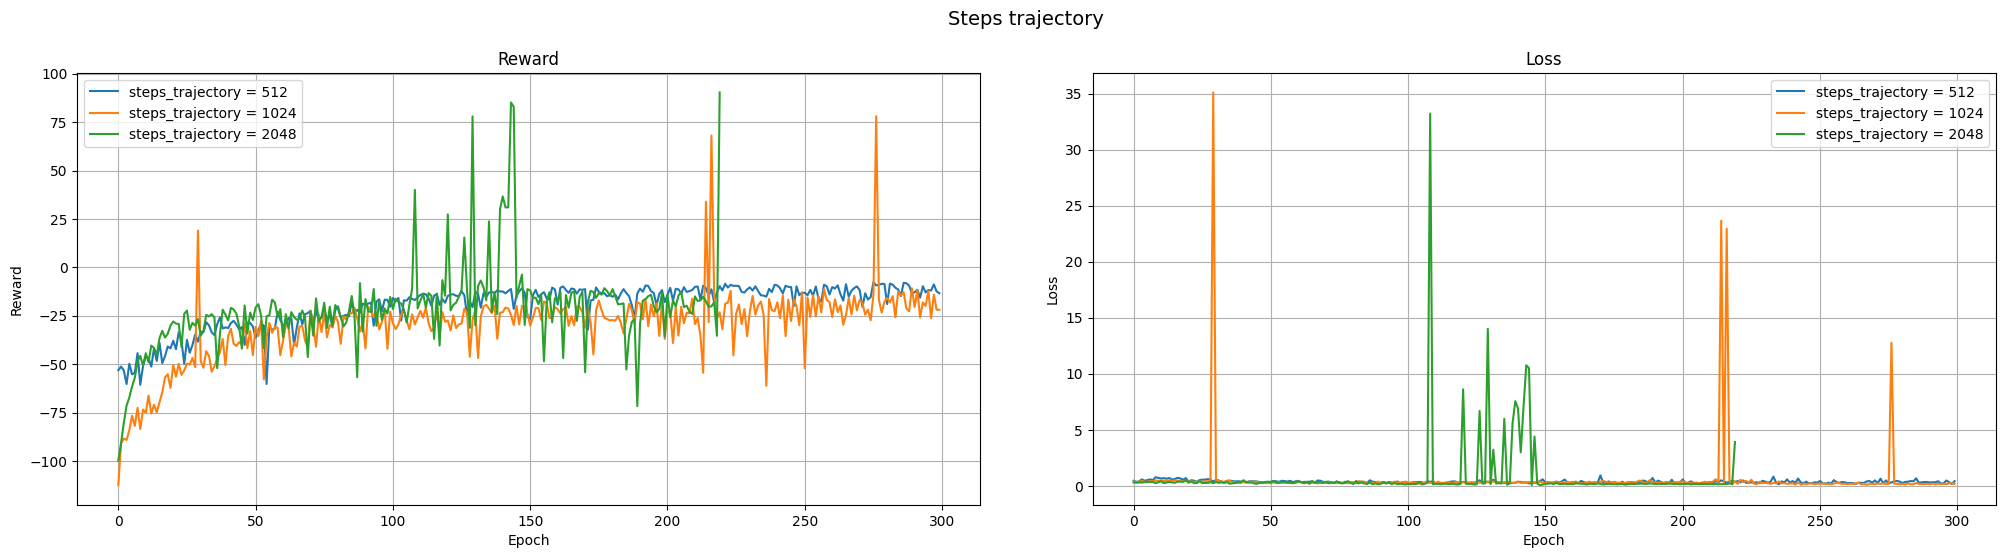

In [24]:
experiment_steps_trajectory(env)

clip_ratio = 0.1 model train


Avg Reward: -23.661214664054782, Loss: 0.2817384265785222: 100%|██████████| 300/300 [05:29<00:00,  1.10s/it]


clip_ratio = 0.2 model train


Avg Reward: 90.42317716905363, Loss: 32.65254940725863:  99%|█████████▉| 297/300 [05:17<00:03,  1.07s/it]    



Task is completed for 297 episodes
clip_ratio = 0.3 model train


Avg Reward: 91.75443834030722, Loss: 7.422049349360168:  71%|███████▏  | 214/300 [03:41<01:29,  1.04s/it] 


Task is completed for 214 episodes


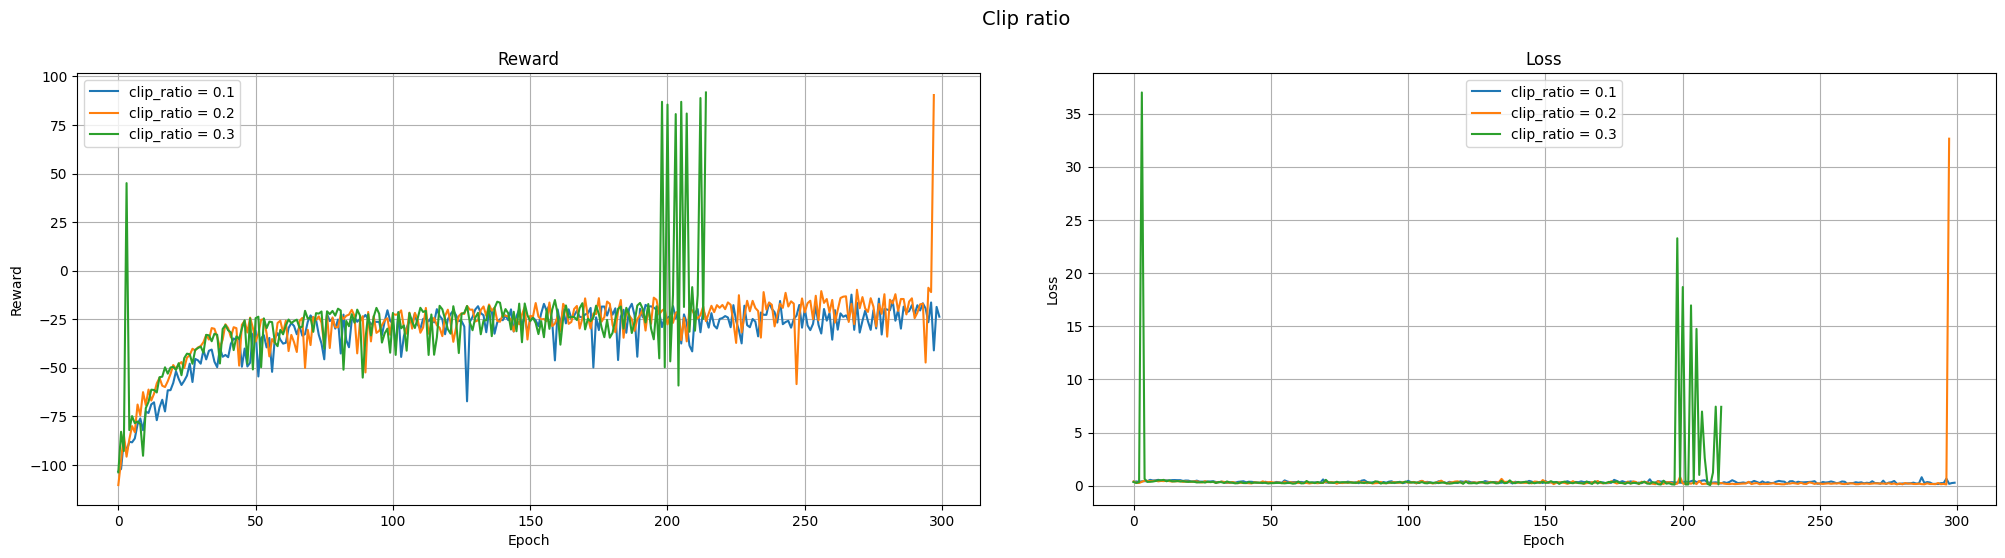

In [25]:
experiment_clip_ratio(env)

normalize_advantages = True model train


Avg Reward: 93.26455486845683, Loss: 14.752550724148751:  97%|█████████▋| 291/300 [04:59<00:09,  1.03s/it]



Task is completed for 291 episodes
normalize_advantages = False model train


Avg Reward: -0.44345599908515154, Loss: -0.007356891047675162: 100%|██████████| 300/300 [05:07<00:00,  1.02s/it]


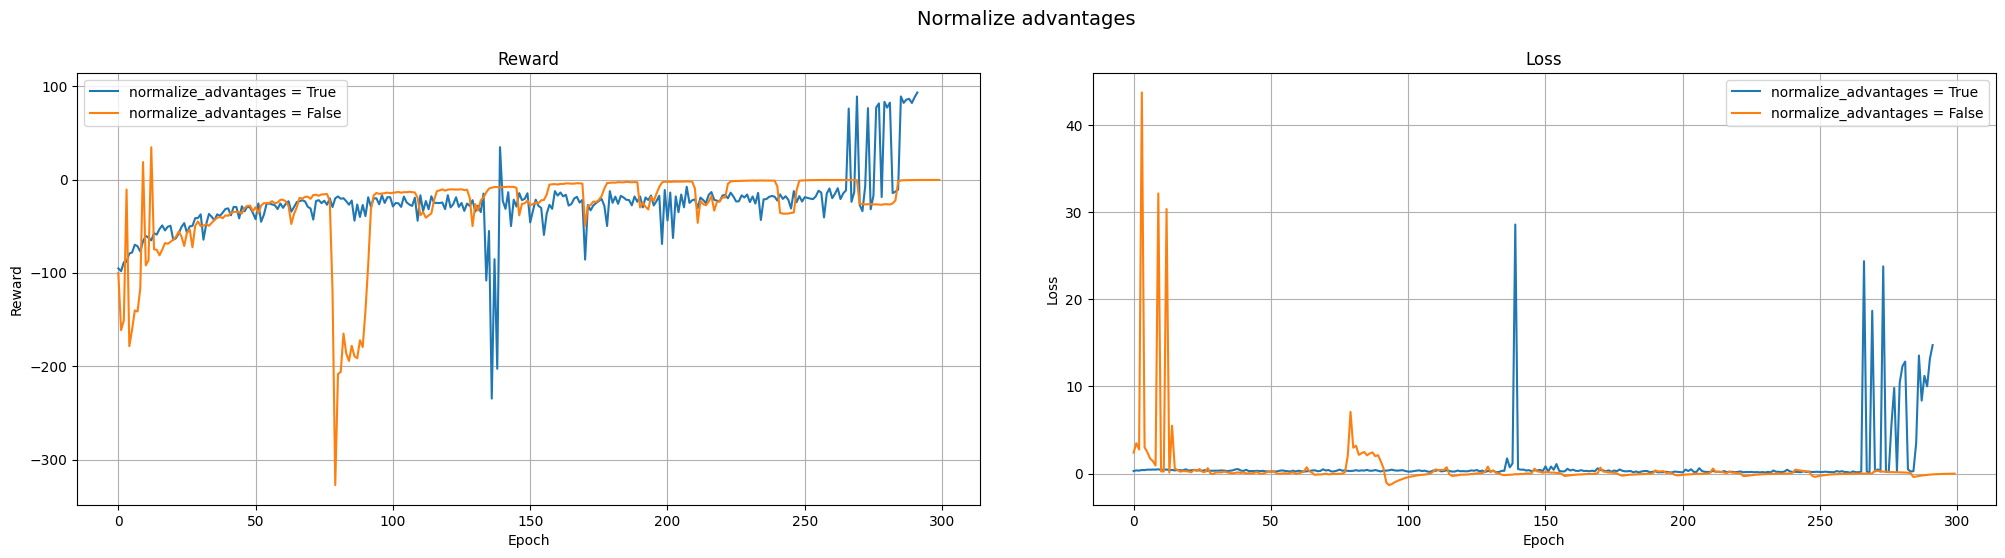

In [26]:
experiment_normalize_advantages(env)

epochs = 10 model train


Avg Reward: -22.397213678971795, Loss: 0.11770823507322348: 100%|██████████| 300/300 [05:06<00:00,  1.02s/it]


epochs = 20 model train


Avg Reward: 91.7744429648964, Loss: 6.509980779699982:  41%|████▏     | 124/300 [03:23<04:48,  1.64s/it]    



Task is completed for 124 episodes
epochs = 30 model train


Avg Reward: 94.11249966593049, Loss: 6.169717780749003:  40%|███▉      | 119/300 [04:20<06:36,  2.19s/it]  


Task is completed for 119 episodes


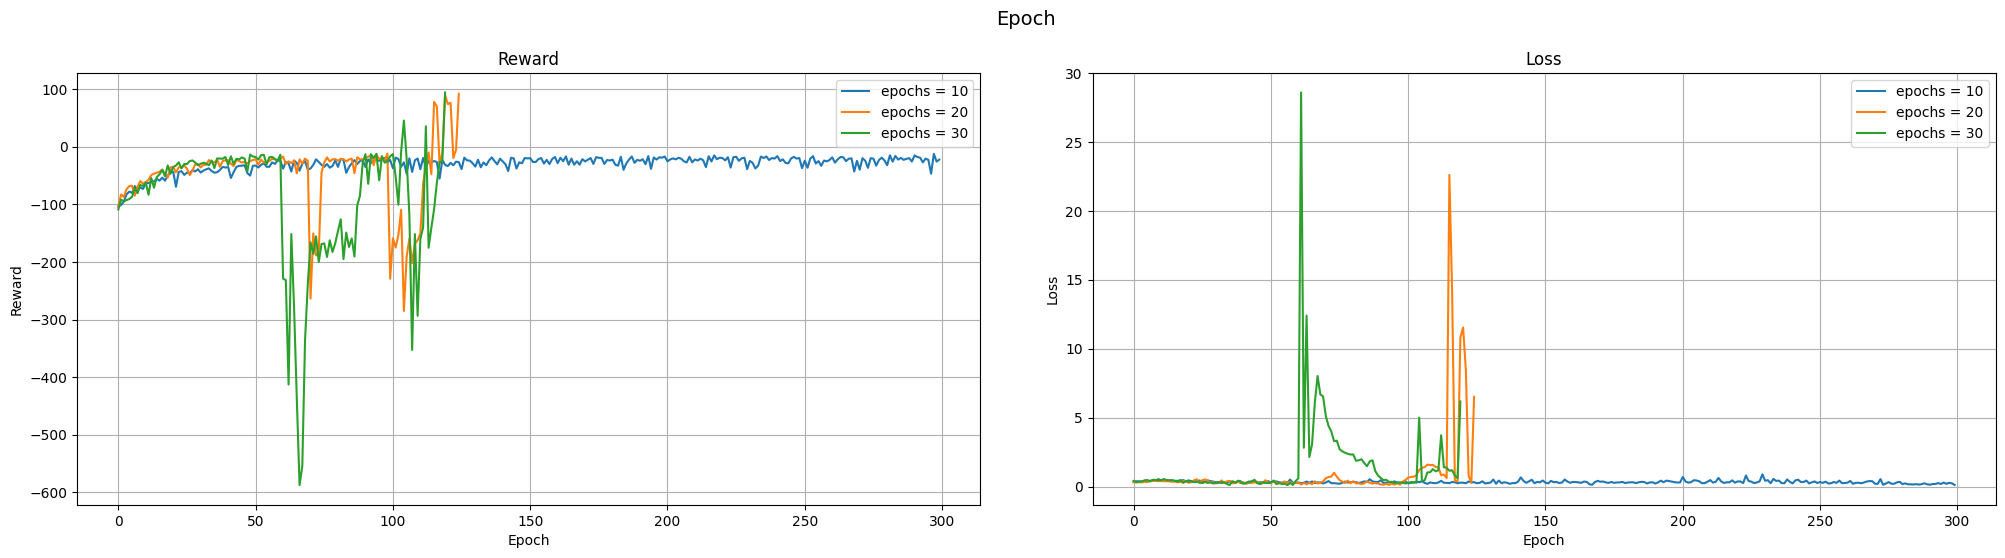

In [27]:
experiment_epoch(env)

## Визуализация результатов

Функция визуализации обученной модели (запись сохраняется в папку `videos`)

In [28]:
def visualize_agent_performance(agent):
    env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
    env = RecordVideo(env,
                     video_folder="./videos",
                     name_prefix="mountaincar_ppo",
                     episode_trigger=lambda x: True)

    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = agent.actor.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward


    env.close()
    print("Видео сохранены в папку ./videos")

Обучение агента

In [29]:
env = gym.make("MountainCarContinuous-v0")
agent = PPOAgent(env, Params(num_episodes=500, epochs=20, batch_size=128, clip_ratio=0.3, entropy_coef=0.05))
results = train(agent, env)

Avg Reward: 94.37520813028819, Loss: 13.832125449180603:  76%|███████▋  | 382/500 [06:47<02:05,  1.07s/it]   


Task is completed for 382 episodes


### Графики его обучения

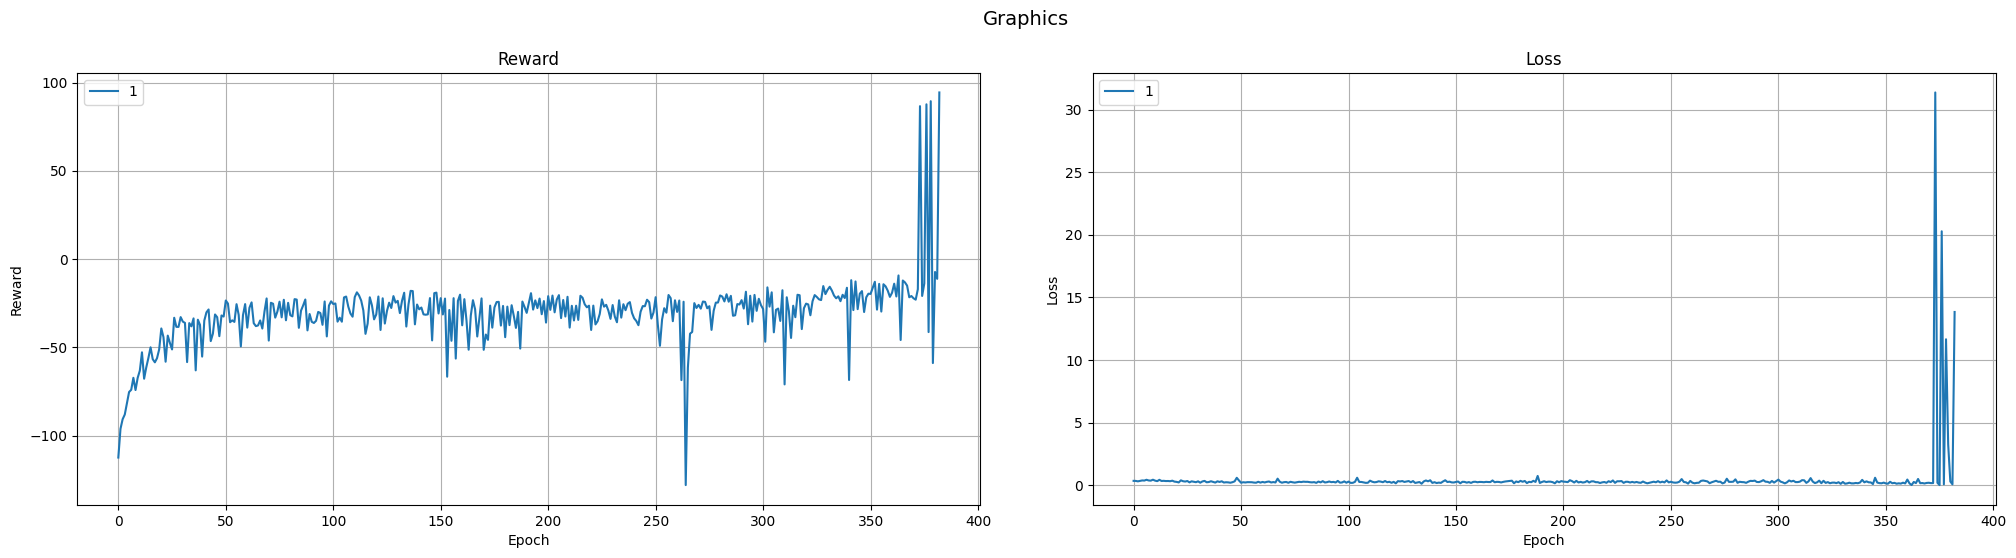

In [30]:
plot_graphics([results], ['1'], "Graphics")

### Визуализация

In [31]:
visualize_agent_performance(agent)

Видео сохранены в папку ./videos
